To do:
1. Duplicate nodes which have more than one incoming edges
2. max spanning tree for each of those subgraphs
3. Edge sequence DAG
4. Merge Edge sequences
5. merged Table

In [19]:
from clustering import dummy
import sequence.duplication
import utils.draw

graph = dummy.get_graph()
coms = dummy.get_extended_communities()
ext_coms = []

for com in coms:
    ext_coms.append(sequence.duplication.duplicate(graph.subgraph(com)))
for i in range(len(coms)):
    print(f"Community {coms[i]}\n{' <break> '.join([str(ext_com.edges()) for ext_com in ext_coms[i]])}\n")

community = ext_coms[1][1]

#Tables: 13
Community {'`instructor`', '`department`', '`advisor`', '`student`'}
[('`instructor`', '`department`_dup_1'), ('`advisor`', '`instructor`'), ('`advisor`', '`student`'), ('`student`', '`department`')]

Community {'`time_slot`', '`takes`', '`teaches`', '`classroom`', '`section`', '`course`', '`instructor`', '`student`'}
[('`takes`', '`student`'), ('`takes`', '`section`_dup_1'), ('`section`_dup_1', '`course`'), ('`section`_dup_1', '`classroom`'), ('`section`_dup_1', '`time_slot`')] <break> [('`section`', '`classroom`_dup_1'), ('`section`', '`course`_dup_1'), ('`section`', '`time_slot`_dup_1'), ('`teaches`', '`section`'), ('`teaches`', '`instructor`')]

Community {'`prereq`', '`department`', '`course`'}
[('`prereq`', '`course`'), ('`course`', '`department`')]



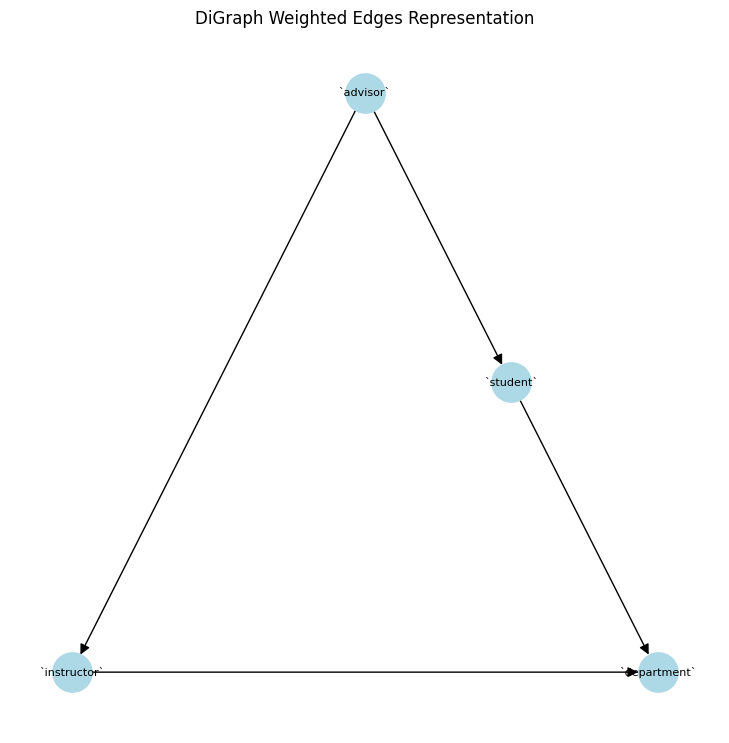

In [20]:
utils.draw.draw_planar_graph(graph.subgraph(coms[0]))

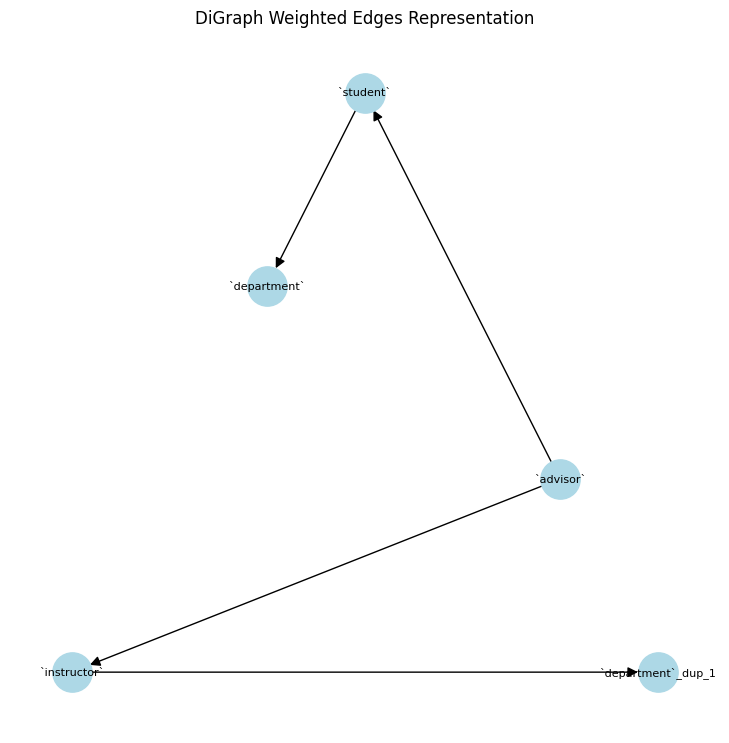

In [21]:
utils.draw.draw_planar_graph(ext_coms[0][0])

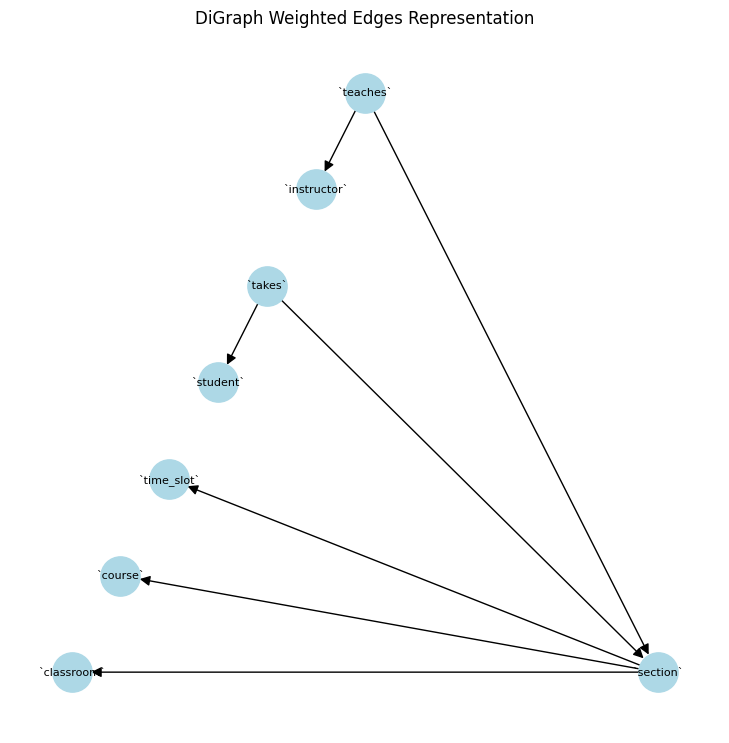

In [22]:
utils.draw.draw_planar_graph(graph.subgraph(coms[1]))

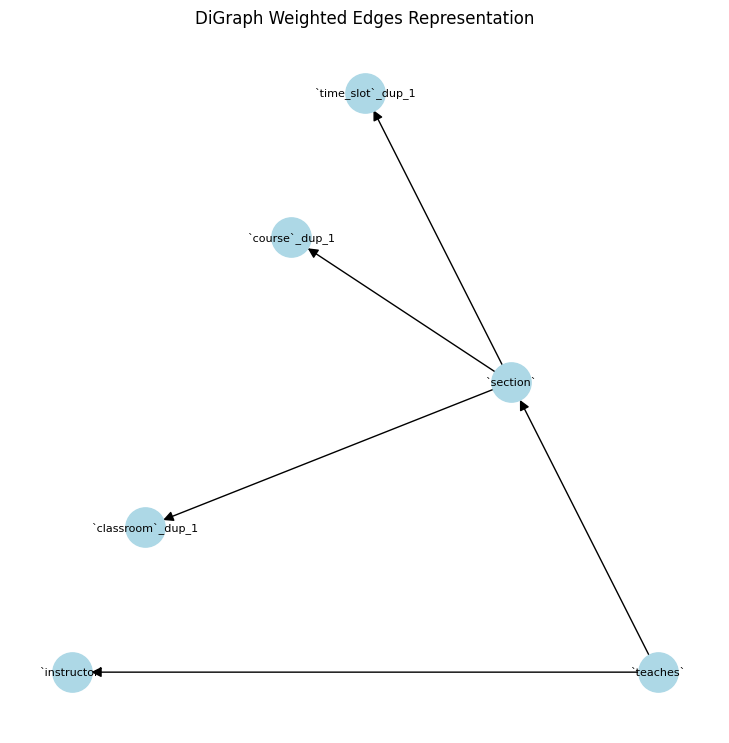

In [23]:
utils.draw.draw_planar_graph(ext_coms[1][1])

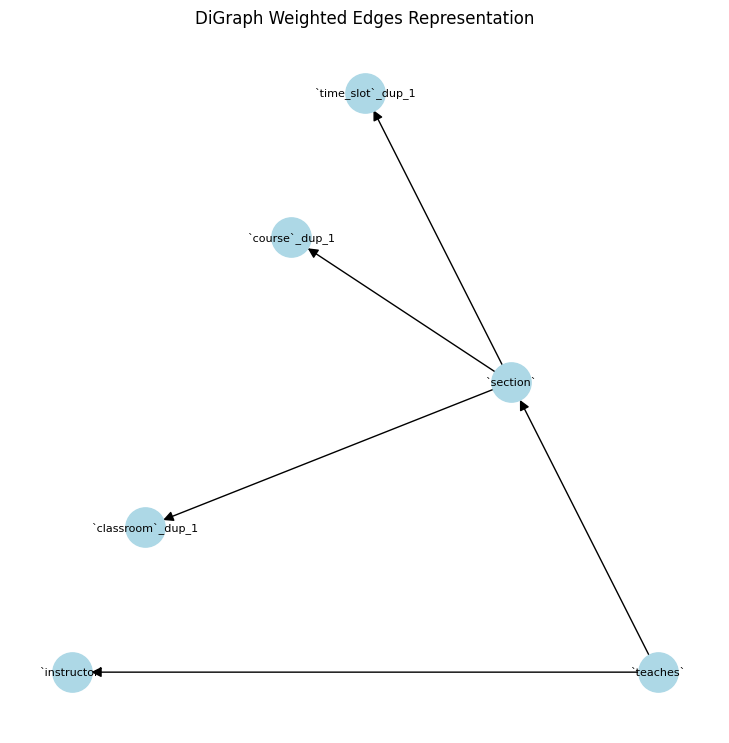

In [24]:
utils.draw.draw_planar_graph(community)

In [25]:
import join.dag
queue = join.dag.process_dag(community)
queue = join.dag.rename_duplicated_nodes(queue)
print(queue)

[('`teaches`', '`instructor`'), ('`section`', '`classroom`'), ('`section`', '`course`'), ('`section`', '`time_slot`'), ('`teaches`', '`section`')]


In [26]:
from pprint import pprint
from clustering import dummy

table_data = dummy.get_parsed_data()
# print([table['table_name'] for table in table_data])
# table_map = {table['table_name']: table for table in table_data}
# pprint(table_map["`section`"])
# pprint(table_map["`course`"])
# import join.merge
# join.merge.generate_merge_table_columns(table_map["`section`"], table_map["`course`"])

In [27]:
import join.merge
sql_joins, _ = join.merge.generate_sql_joins(table_data, queue)

print("SQL Joins:")
for join in sql_joins:
    print(join, "\n")


SQL Joins:
CREATE TABLE teaches_instructor AS SELECT teaches.instr_id, teaches.semester, teaches.year, teaches.teaches_created, teaches.sec_id, teaches.course_id, instructor.dept_name, instructor.instr_name, instructor.instr_created, instructor.salary FROM instructor INNER JOIN teaches ON teaches.instr_id = instructor.instr_id; 

CREATE TABLE section_classroom AS SELECT section.time_slot_id, section.semester, section.year, section.room_number, section.sec_id, section.building, section.course_id, classroom.capacity FROM classroom INNER JOIN section ON section.building = classroom.building AND section.room_number = classroom.room_number; 

CREATE TABLE section_classroom_course AS SELECT section_classroom.time_slot_id, section_classroom.semester, section_classroom.year, section_classroom.room_number, section_classroom.capacity, section_classroom.sec_id, section_classroom.building, section_classroom.course_id, course.dept_name, course.title, course.credits FROM course INNER JOIN section_cl

# Final Table for Section

CREATE TABLE takes_student_section_classroom_course_time_slot AS

SELECT
 takes_student.semester, takes_student.course_id, takes_student.tot_cred, takes_student.year, takes_student.grade,
 takes_student.ID, takes_student.timestamp, takes_student.name, takes_student.dept_name, takes_student.sec_id,
 section_classroom_course_time_slot.day, section_classroom_course_time_slot.start_time, section_classroom_course_time_slot.credits,
 section_classroom_course_time_slot.time_slot_id, section_classroom_course_time_slot.capacity,
 section_classroom_course_time_slot.end_time, section_classroom_course_time_slot.title,
 section_classroom_course_time_slot.room_number, section_classroom_course_time_slot.building

FROM
 section_classroom_course_time_slot INNER JOIN takes_student ON
 takes_student.course_id = section_classroom_course_time_slot.course_id AND
 takes_student.sec_id = section_classroom_course_time_slot.sec_id AND
 takes_student.semester = section_classroom_course_time_slot.semester AND
 takes_student.year = section_classroom_course_time_slot.year;

# Objects from final table for Section

course_id, takes_student.ID, sec_id, time_slot_id, room_number, building

# Final Table for Advisor Tree
CREATE TABLE advisor_instructor_department_student_department AS 

SELECT advisor_instructor_department.dept_name, advisor_instructor_department.building, advisor_instructor_department.salary, advisor_instructor_department.timestamp, advisor_instructor_department.name, advisor_instructor_department.budget, advisor_instructor_department.dept_name, advisor_instructor_department.ID, advisor_instructor_department.s_ID, advisor_instructor_department.i_ID, student_department.tot_cred, student_department.ID, student_department.timestamp, student_department.name

FROM student_department INNER JOIN advisor_instructor_department ON advisor_instructor_department.s_ID = student_department.ID;